This notebook will implement a machine learning algorithm which predicts the review score of a product given the text of the product review on a scale of 1-10. The dataset was compiled from boargame geek website by the organizer of the Portland Data Science Meetup Group. Over 800 000 labeled reviews were given as training data

Import necessary modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the file using pandas
df = pd.read_csv('C:\\Users\\sicel\\Desktop\\Portland Data Science\\Sentiment Analysis\\boardgame-comments-sample.csv')
df.head()

,Compiled from boardgamegeek.com by Matt Borthwick,gameID,rating,comment
0,25308,37111,8.5,++++ Thematic +++ Bluff - Many randomness I ...
1,54313,12,8.0,"""well, that ugly artwork certainly helped imme..."
2,38165,50,8.0,LOVE this game! If only the GF would play it ...
3,56936,1198,5.0,"SET is a good game, in small doses (in my case..."
4,47675,164153,6.0,"So much better than Descent. Better theme, imp..."


In [3]:
# Explore the data file. Print out summary information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 4 columns):
Compiled from boardgamegeek.com by Matt Borthwick    847 non-null int64
gameID                                               847 non-null int64
rating                                               847 non-null float64
comment                                              847 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 26.5+ KB


In [4]:
df.shape

(847, 4)

In [5]:
df.describe()

,Compiled from boardgamegeek.com by Matt Borthwick,gameID,rating
count,847.000000,847.000000,847.000000
mean,94206.848878,48229.654073,7.251677
std,56362.226969,55017.276809,1.679171
min,319.000000,3.000000,1.000000
25%,43919.000000,2223.000000,6.000000
50%,93257.000000,25613.000000,7.500000
75%,143787.000000,84876.000000,8.000000
max,193115.000000,209010.000000,10.000000


In [6]:
# lowercase all comments and rename 'long column'
df['comment'] = df.comment.str.lower()
df = df.rename(columns = {'Compiled from boardgamegeek.com by Matt Borthwick': 'userid'})

In [7]:
# Create a comment length column
df['length'] = df.comment.apply(lambda x: len(x))
df.head()

,userid,gameID,rating,comment,length
0,25308,37111,8.5,++++ thematic +++ bluff - many randomness i ...,255
1,54313,12,8.0,"""well, that ugly artwork certainly helped imme...",100
2,38165,50,8.0,love this game! if only the gf would play it ...,103
3,56936,1198,5.0,"set is a good game, in small doses (in my case...",374
4,47675,164153,6.0,"so much better than descent. better theme, imp...",329


Text(0,0.5,'Count')

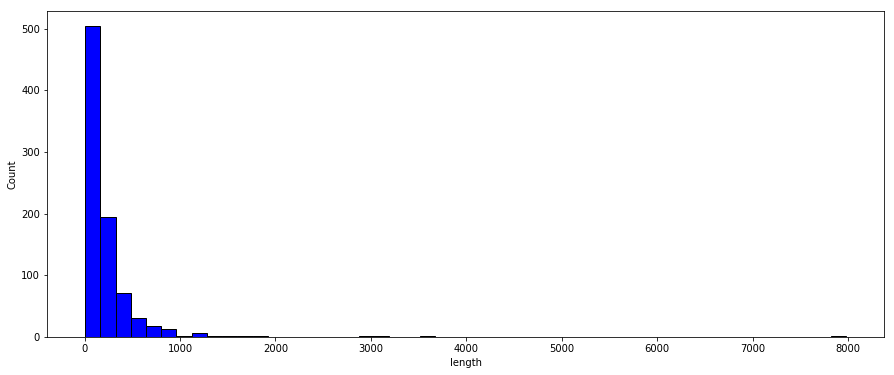

In [8]:
# Create a histogram of column length
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.hist(df['length'], color = 'blue', edgecolor = 'black', bins = 50)
plt.xlabel('length')
plt.ylabel('Count')

As can be seen from the histogram, most of the comments contain 1-1000 characters. It has a skewed to the left kind of distribution. Let's zoom in around the distribution

Text(0,0.5,'Count')

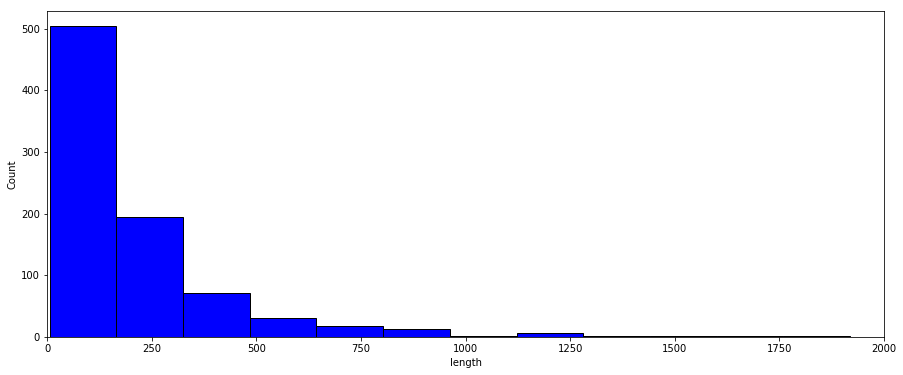

In [9]:
plt.hist(df['length'], color = 'blue', edgecolor = 'black', bins = 50)
plt.xlabel('length')
plt.xlim(0,2000)
plt.ylabel('Count')

Now I would like to plot the histrogram distribution of comment review scores/ratings. The distribution is more skewed to the right and looks Normal on the right

Text(0,0.5,'Count')

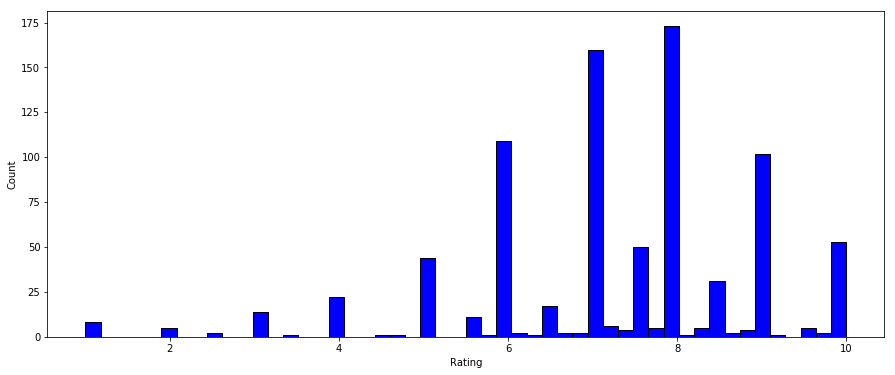

In [10]:
plt.hist(df['rating'], color = 'blue', edgecolor = 'black', bins = 50)
plt.xlabel('Rating')
plt.ylabel('Count')

Figured it might be easier to work with integer ratings rather than floats

In [11]:
df['rating'] = df['rating'].apply(round)

It is better to work with text which has stopwords removed

In [12]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
df['comment_no_stopwords'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sicel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,userid,gameID,rating,comment,length,comment_no_stopwords
0,25308,37111,8,++++ thematic +++ bluff - many randomness i ...,255,++++ thematic +++ bluff - many randomness real...
1,54313,12,8,"""well, that ugly artwork certainly helped imme...",100,"""well, ugly artwork certainly helped immerse e..."
2,38165,50,8,love this game! if only the gf would play it ...,103,love game! gf would play me. tired end day bas...
3,56936,1198,5,"set is a good game, in small doses (in my case...",374,"set good game, small doses (in case small dose..."
4,47675,164153,6,"so much better than descent. better theme, imp...",329,"much better descent. better theme, improved ru..."


Makes sense to check if there are any correlations between numeric columns. No strong correlations observed

In [13]:
df.corr()

,userid,gameID,rating,length
userid,1.000000,-0.007805,-0.017345,0.006752
gameID,-0.007805,1.000000,0.203491,0.079922
rating,-0.017345,0.203491,1.000000,-0.016838
length,0.006752,0.079922,-0.016838,1.000000


I decided to divide the dataset into 3 core classes and turn this into a classification problem for simplicity. The goal is to apply a machine learning model which can predict the comment rating for each category/class

In [14]:
# Create 3 category groups: negative (1-4 rating), neutral (5), and positive (6-10)
df_pos = df[(df['rating'] >=6) & (df['rating'] <= 10)]
# Give this category a numerical score of 8
df_pos['cat_rating'] = df_pos.apply(lambda row: 8 if row['rating'] <= 10 else 0, axis = 1)
df_pos.tail()

,userid,gameID,rating,comment,length,comment_no_stopwords,cat_rating
842,157377,144733,8,"the more i play, the more i love this game.",44,"play, love game.",8
843,165589,40692,7,"my first venture into the hobby and boy, am i ...",287,"first venture hobby boy, glad did. close frien...",8
844,824,158899,8,"one of the best ""family style"" games out there...",206,"one best ""family style"" games there. love prog...",8
845,90173,8217,7,nice little game for two players. an english ...,71,nice little game two players. english paste-up...,8
846,109519,13,7,the vanilla version of this game has it's flaw...,144,"vanilla version game flaws. enjoyed past, ever...",8


In [15]:
df_neut = df[(df['rating'] == 5)]
df_neut['cat_rating'] = df_neut.apply(lambda row: 5 if row['rating'] == 5 else 0, axis = 1)

In [16]:
df_neg = df[(df['rating'] < 5)]
df_neg['cat_rating'] = df_neg.apply(lambda row: 2 if row['rating'] <5 else 0, axis = 1)

Concatenate the DataFrames

In [17]:
frames = [df_pos, df_neut, df_neg]
df_cat = pd.concat(frames)
df_cat.head()

,userid,gameID,rating,comment,length,comment_no_stopwords,cat_rating
0,25308,37111,8,++++ thematic +++ bluff - many randomness i ...,255,++++ thematic +++ bluff - many randomness real...,8
1,54313,12,8,"""well, that ugly artwork certainly helped imme...",100,"""well, ugly artwork certainly helped immerse e...",8
2,38165,50,8,love this game! if only the gf would play it ...,103,love game! gf would play me. tired end day bas...,8
4,47675,164153,6,"so much better than descent. better theme, imp...",329,"much better descent. better theme, improved ru...",8
5,94529,31260,8,very tense and fun and i love pondering my str...,149,tense fun love pondering strategy beginning ga...,8


I wanted to see if there were significant differences in between the category scores with respect to the length of the review comments. Found that low score comments were longer on average but the difference is not that significant

In [18]:
dfz = df_cat[['rating', 'length', 'cat_rating']].groupby('cat_rating', as_index=False)
dfz.describe()

rating                                               length              \
   count      mean       std  min  25%  50%  75%   max  count        mean   
0   53.0  3.018868  1.100534  1.0  2.0  3.0  4.0   4.0   53.0  250.339623   
1   45.0  5.000000  0.000000  5.0  5.0  5.0  5.0   5.0   45.0  153.888889   
2  749.0  7.696929  1.166719  6.0  7.0  8.0  8.0  10.0  749.0  229.598131   

  ...                 cat_rating                                     
  ...     75%     max      count mean  std  min  25%  50%  75%  max  
0 ...   327.0  1470.0       53.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
1 ...   194.0   848.0       45.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0  
2 ...   262.0  7977.0      749.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0  

[3 rows x 24 columns]

# ML ALGORITHM TESTING

I started applying Random Forest algorithm to the dataset

In [19]:
# Import Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\sicel\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Split the dataset into 80% training set and 20% training set

In [20]:
dfm = df_cat
X = dfm['comment_no_stopwords'] # Features
y = dfm['cat_rating']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

Use TF-IDF statistic (term frequency-inverse document frequency) to turn comment text into numerical data. TF determines the frequency of a word and IDF decreases the weight for commonly used words and increases the weight of less commonly used words

In [21]:
tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train_mt = tf_vect.fit_transform(X_train)
X_test_mt = tf_vect.transform(X_test)

# Train the model on a training set

clf = RandomForestClassifier(n_estimators = 10)
clf.fit(X_train_mt, y_train)

# Predict on a training dataset

y_pred = clf.predict(X_test_mt)

# Print the model accuracy score and RMSE

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
mean_squared_error(y_test, y_pred)

Accuracy: 0.9117647058823529


1.7470588235294118

At first glance, an accuracy score of 90% seems really good but there is a catch. Print out the classification report and confusion matrix to see this. The classifier can predict one class (positive class) with high precision but is not very good at predicting the other classes. Is it because the data is skewed to the right as seen in the histogram distribution earlier? In a confusion matrix, correctly predicted values are on the diagonal axis and in this case only one class was correctly predicted. This is a problem!

In [22]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         5
          5       0.00      0.00      0.00         9
          8       0.92      0.99      0.95       156

avg / total       0.84      0.91      0.88       170



In [23]:
print(confusion_matrix(y_test, y_pred))

[[  0   0   5]
 [  0   0   9]
 [  1   0 155]]


In [24]:
# You can print out the number of unique elements of an array that the model can predict by the following:

print(np.unique(y_pred))

[2 8]


Next I wanted to try a different ML algorithm, the Naive Bayes Classifier

In [25]:
# Train

X_train2 = tf_vect.fit_transform(X_train)
X_test2 = tf_vect.transform(X_test)
NBclassifier1 = MultinomialNB()
NBclassifier1.fit(X_train2, y_train)

# Predict on a training set

Y_predict = NBclassifier1.predict(X_test2)

# Print accuracy score and RMSE

print("Accuracy:", metrics.accuracy_score(y_test, Y_predict))
mean_squared_error(y_test, Y_predict)

Accuracy: 0.9176470588235294


1.535294117647059

The model has 92% accuracy but is also predicting one majority class really well

In [26]:
print(classification_report(y_test, Y_predict))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         5
          5       0.00      0.00      0.00         9
          8       0.92      1.00      0.96       156

avg / total       0.84      0.92      0.88       170



In [27]:
print(confusion_matrix(y_test, Y_predict))

[[  0   0   5]
 [  0   0   9]
 [  0   0 156]]


In [28]:
print(np.unique(Y_predict))

[8]


# DEALING WITH IMBALANCED DATASETS

To improve the accuracy of the model to predict the other minority classes, we hae to find a way to balnce the data. I found this article to be very helpful: https://elitedatascience.com/imbalanced-classes

In [29]:
# Start by counting each class to find out where the imbalance is

dfm['cat_rating'].value_counts()

8    749
2     53
5     45
Name: cat_rating, dtype: int64

Approach #1 - Up-sample the minority class

In [30]:
from sklearn.utils import resample

In [31]:
# Separate each class into its own DataFrame

df_majority = dfm[dfm.cat_rating==8]
df_neutral = dfm[dfm.cat_rating==5]
df_minority = dfm[dfm.cat_rating==2]

Upsampling is usually done by resampling with replacement

In [32]:
df_minority_upsampled = resample(df_minority,            
                                replace=True,                        # sample with replacement
                                n_samples=749,                       # to match majority class
                                random_state=123)                    # reproducible results
df_neutral_upsampled = resample(df_neutral,
                               replace=True,
                               n_samples=749,
                               random_state=123)
len(df_minority_upsampled)

749

In [33]:
# Concatenate the DataFrames

dfm_upsampled = pd.concat([df_majority, df_neutral_upsampled, df_minority_upsampled])
dfm_upsampled['cat_rating'].value_counts()

5    749
8    749
2    749
Name: cat_rating, dtype: int64

Train the ML algorithm this time using the balanced dataset

In [34]:
# Model 1 - Random Forest

X = dfm_upsampled['comment_no_stopwords'] # Features
y = dfm_upsampled['cat_rating']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train_mt = tf_vect.fit_transform(X_train)
X_test_mt = tf_vect.transform(X_test)

# Train the model on a training set

clf = RandomForestClassifier(n_estimators = 10)
clf.fit(X_train_mt, y_train)

# Predict on a training dataset

y_pred = clf.predict(X_test_mt)

# Print the model accuracy score and RMSE

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
mean_squared_error(y_test, y_pred)

Accuracy: 0.9911111111111112


0.2

The accuracy score increases. The RMSE is even better. The model is now predicting all 3 classes with a good F1 score

In [35]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          2       0.99      1.00      0.99       153
          5       0.99      1.00      0.99       152
          8       1.00      0.97      0.99       145

avg / total       0.99      0.99      0.99       450



In [36]:
print(confusion_matrix(y_test, y_pred))

[[153   0   0]
 [  0 152   0]
 [  2   2 141]]


In [37]:
print(np.unique(y_pred))

[2 5 8]


In [38]:
# Model 2 - Naive Bayes

X_train4 = tf_vect.fit_transform(X_train)
X_test4 = tf_vect.transform(X_test)
NBclassifier2 = MultinomialNB()
NBclassifier2.fit(X_train4, y_train)



Y_predict3 = NBclassifier2.predict(X_test4)



print("Accuracy:", metrics.accuracy_score(y_test, Y_predict3))
mean_squared_error(y_test, Y_predict3)

Accuracy: 0.9422222222222222


1.42

The accuracy of the model goes up and RMSE improves. The model is predicting all 3 classes with good F1 scores

In [39]:
print(classification_report(y_test, Y_predict3))

             precision    recall  f1-score   support

          2       0.91      1.00      0.95       153
          5       0.93      1.00      0.97       152
          8       1.00      0.82      0.90       145

avg / total       0.95      0.94      0.94       450



In [40]:
print(confusion_matrix(y_test, Y_predict3))

[[153   0   0]
 [  0 152   0]
 [ 15  11 119]]


In [41]:
print(np.unique(Y_predict3))

[2 5 8]


# CONCLUSION

We have seen that using the up-sampling technique to create a balanced dataset improves the accuracy of the model as well as the RMSE. It would be interesting to test the preformance of the model on unseen test data. Another way to balance a dataset if to use the down-sampling technique. You can also explore using penalized ML algorithms and test their effectiveness in improving model accuracy as recommended in the article mentioned earlier.